In [1]:
import pandas as pd
from pandas.stats.api import ols

import statsmodels.formula.api as sm
import statsmodels.formula.api as smf

import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

import patsy

import seaborn as sns
from seaborn import plt

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.grid_search import GridSearchCV

from glob import glob

/Users/danvigil/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/danvigil/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read csvs and concat into pd df

path = '/Users/danvigil/ds/metis/metisgh/sf16_ds4/local/'                     
all_files = glob(path + "movies*.csv")

df_from_each_file = [pd.read_csv(f) for f in all_files]
movies_raw = pd.concat(df_from_each_file, ignore_index=True)

In [3]:
# validate that df contains all 16,700 films on BoxOfficeMojo

print(len(movies_raw))
movies_raw.sample(10)

16706


,dom_total,genre,open_weekend,rating,release_date,runtime,studio,title
3263,NaN,Documentary,5925.0,Unrated,2013-11-29,77.0,Content Media,The Unbelievers
13011,935.0,Foreign,459.0,Unrated,2004-12-22,100.0,Wolfe Releasing,Producing Adults
5903,60902.0,Unknown,10003.0,R,2002-04-19,109.0,Lions Gate,Chelsea Walls
9941,604.0,Documentary,604.0,Unrated,2004-12-03,87.0,Leisure Time,"Jesus, You Know"
4146,36403064.0,Fantasy Comedy,5803848.0,PG,1984-09-21,93.0,Universal,All of Me
14728,5555305.0,Unknown,1980105.0,R,1983-08-05,109.0,Fox,The Star Chamber
16469,NaN,Foreign,NaN,Unrated,1959-06-22,91.0,Janus Films,Wild Strawberries
4400,41526.0,Unknown,20361.0,PG,1989-10-27,85.0,Miramax,Animal Behavior
6395,384029.0,Music Drama,70460.0,PG-13,2006-11-10,104.0,MGM,Copying Beethoven
15687,13670.0,Documentary,418.0,Unrated,2014-06-06,87.0,Icarus Films,Tosca's Kiss


In [98]:
# drop movies with NaNs, verify count and validate 

movies_df = movies_raw.dropna()

print(len(movies_df))
movies_df.sample(100)

11784


,dom_total,genre,open_weekend,rating,release_date,runtime,studio,title
7524,351416.0,Romantic Comedy,197861.0,R,2008-09-05,103.0,Roadside Attractions,Everybody Wants to Be Italian
7618,72210.0,Drama,37924.0,PG-13,2007-08-24,96.0,"Monterey Media, Inc.",Eye of the Dolphin
11523,7696134.0,Action Comedy,4200586.0,R,2015-01-23,106.0,Lionsgate,Mortdecai
14268,224614.0,Period Drama,9359.0,PG-13,2008-08-01,93.0,First Independent Pictures,Sixty Six
204,162685.0,Romance,18006.0,R,2015-04-03,95.0,IFC,5 to 7
2013,8906823.0,Fantasy Drama,3607545.0,PG,1991-09-20,93.0,Columbia,Late for Dinner
2399,155874.0,Comedy,75730.0,R,2005-08-26,99.0,Televisa Cine,Matando Cabos
5595,132716677.0,Comedy,31101026.0,PG-13,2003-03-07,105.0,Buena Vista,Bringing Down the House
13659,13109815.0,Adventure,5135369.0,R,2011-10-28,120.0,FilmDistrict,The Rum Diary
7308,14902041.0,Comedy,119080.0,R,1999-04-23,105.0,Paramount,Election


In [6]:
movies_df.info()
release_date = datetime.striptime.movies_df["release_date"]
date_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11784 entries, 1 to 16705
Data columns (total 8 columns):
dom_total       11784 non-null float64
genre           11784 non-null object
open_weekend    11784 non-null float64
rating          11784 non-null object
release_date    11784 non-null object
runtime         11784 non-null float64
studio          11784 non-null object
title           11784 non-null object
dtypes: float64(3), object(5)
memory usage: 828.6+ KB


NameError: name 'datetime' is not defined

In [7]:
#Show correlations

movies_df.corr()

,dom_total,open_weekend,runtime
dom_total,1.000000,0.892954,0.176916
open_weekend,0.892954,1.000000,0.140082
runtime,0.176916,0.140082,1.000000


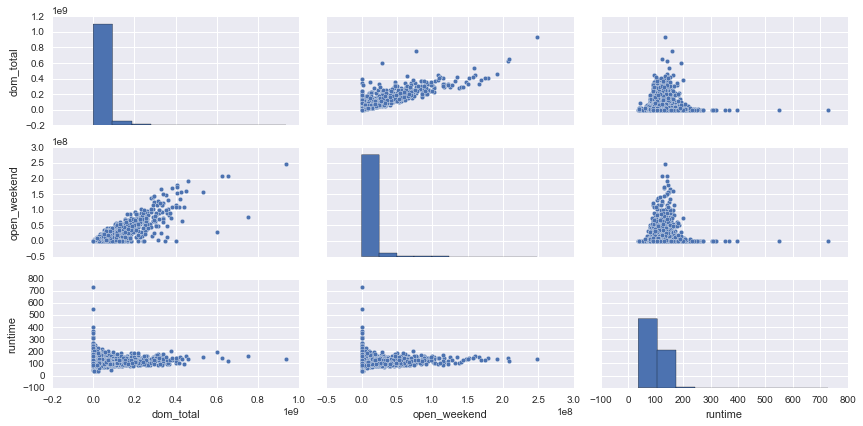

In [8]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(movies_df, size = 2, aspect=2)

In [ ]:
# print(result.params)

In [103]:
#convert release_date to datetime
movies_df["release_date"] = pd.to_datetime(movies_df["release_date"])
movies_df["release_date"] = pd.to_datetime(movies_df["release_date"])
movies_df["month"] = movies_df["release_date"].apply(lambda x: x.to_datetime().month)

/Users/danvigil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/danvigil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/danvigil/anaconda/lib/python3.5/site-packages/pandas/core/series.py:2292: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)
/Users/danvigil/anaconda/l

In [10]:
movies_df.head()

,dom_total,genre,open_weekend,rating,release_date,runtime,studio,title,month
1,52384.0,Animation,478.0,R,2008-12-12,78.0,Regent Releasing,$9.99,12
2,15919.0,Thriller,8372.0,Unrated,2012-08-10,96.0,Truly Indie,$upercapitalist,8
9,53895.0,Foreign,24120.0,Unrated,2014-10-24,117.0,Film Movement,"1,000 Times Good Night",10
11,72082998.0,Thriller,24727437.0,PG-13,2016-03-11,105.0,Paramount,10 Cloverfield Lane,3
12,14616.0,Drama,4773.0,Unrated,2015-11-11,111.0,Cafe Pictures,10 Days in a Madhouse,11


In [104]:
#create holiday, summer, other features
movies_df["month"] = movies_df["release_date"].apply(lambda x: x.to_datetime().month)

movies_df["holiday"] = movies_df["month"].map(lambda x: 1 if x in [11,12] else 0)
movies_df["summer"] = movies_df["month"].map(lambda x: 1 if x in [6,7] else 0)
movies_df["other"] = movies_df["month"].map(lambda x: 1 if x in [1,2,3,4,5,8,9,10] else 0)

movies_df

/Users/danvigil/anaconda/lib/python3.5/site-packages/pandas/core/series.py:2292: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)
/Users/danvigil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/danvigil/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danvigil/anaconda/lib/python3.5/site-packages/i

,dom_total,genre,open_weekend,rating,release_date,runtime,studio,title,month,holiday,summer,other
1,52384.0,Animation,478.0,R,2008-12-12,78.0,Regent Releasing,$9.99,12,1,0,0
2,15919.0,Thriller,8372.0,Unrated,2012-08-10,96.0,Truly Indie,$upercapitalist,8,0,0,1
9,53895.0,Foreign,24120.0,Unrated,2014-10-24,117.0,Film Movement,"1,000 Times Good Night",10,0,0,1
11,72082998.0,Thriller,24727437.0,PG-13,2016-03-11,105.0,Paramount,10 Cloverfield Lane,3,0,0,1
12,14616.0,Drama,4773.0,Unrated,2015-11-11,111.0,Cafe Pictures,10 Days in a Madhouse,11,1,0,0
13,83291.0,Comedy,35929.0,R,2006-12-01,82.0,ThinkFilm,10 Items or Less,12,1,0,0
16,38178166.0,Romantic Comedy,8330681.0,PG-13,1999-03-31,97.0,Buena Vista,10 Things I Hate About You,3,0,0,1
17,7175592.0,Unknown,3050225.0,R,1983-03-11,103.0,MGM,10 to Midnight,3,0,0,1
18,203373.0,Comedy / Drama,22707.0,PG-13,2012-09-14,100.0,Anchor Bay Films,10 Years,9,0,0,1
19,94784201.0,Period Adventure,35867488.0,PG-13,2008-03-07,109.0,Warner Bros.,"10,000 B.C.",3,0,0,1


In [105]:
# create Dummy Variables

movies_df[['G', 'PG', 'PG13', 'R']] = pd.get_dummies(movies_df["rating"])[['G', 'PG', 'PG-13', 'R']]


/Users/danvigil/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


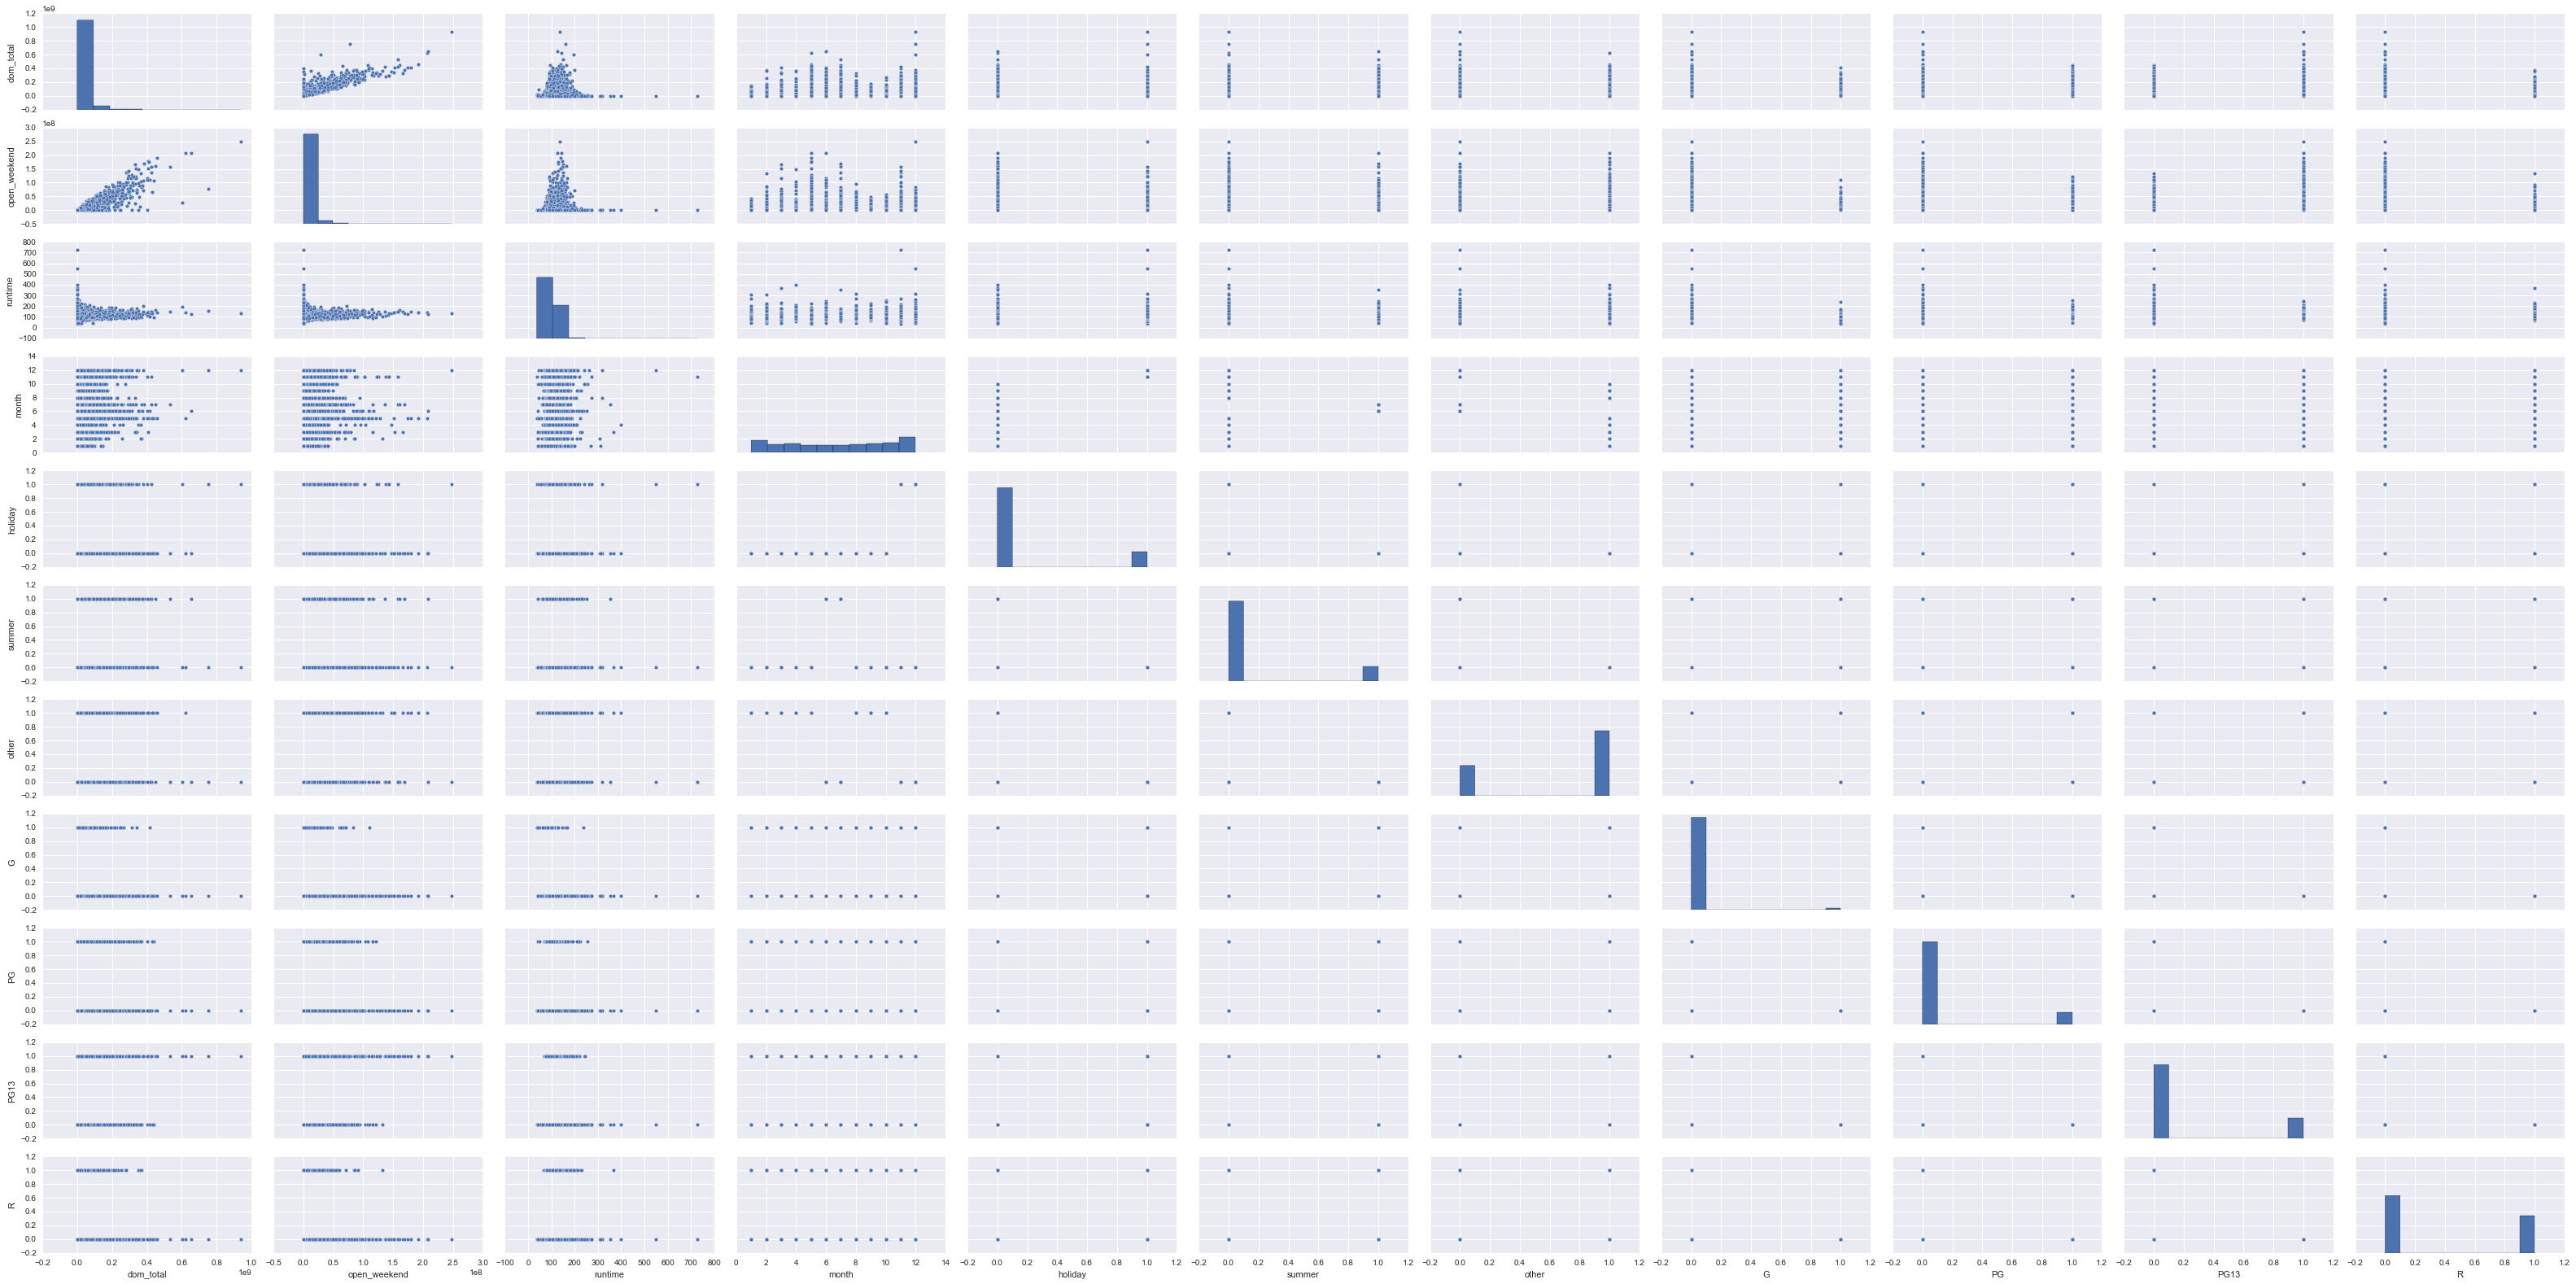

In [36]:
movies_df.corr()
sns.pairplot(movies_df, size = 2, aspect=2)

In [116]:
#Linear Regression

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices("dom_total ~ genre + open_weekend + G + PG + R + holiday + summer + runtime", data=movies_df, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dom_total   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     751.4
Date:                Fri, 07 Oct 2016   Prob (F-statistic):               0.00
Time:                        14:43:56   Log-Likelihood:            -2.1464e+05
No. Observations:               11784   AIC:                         4.294e+05
Df Residuals:                   11712   BIC:                         4.300e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                   -1.353e+07    1.6e+06     -8.440      0.000     -1.67e+07 -1.04e+07
genre[T.Action / Adventure] -1.908e+07   2.45e+06     -7.799      0.000     -2.39e+07 -1.43e+07
genre[T.Action / Crime]     -1.746e+06   3.17e+06     -0.551      0.582     -7.96e+06  4.46e+06
genre[T.Action Comedy]       5.961e+06   2.01e+06      2.968      0.003      2.02e+06   9.9e+06
genre[T.Action Drama]        8.816e+06    2.8e+06      3.147      0.002      3.33e+06  1.43e+07
genre[T.Action Fantasy]     -3.385e+06   5.42e+06     -0.624      0.533      -1.4e+07  7.25e+06
genre[T.Action Horror]      -9.287e+06   3.44e+06     -2.703      0.007      -1.6e+07 -2.55e+06
genre[T.Action Thriller]     7.214e+06   2.31e+06      3.125      0.002      2.69e+06  1.17e+07
genre[T.Adventure]           9.079e+06   3.34e+06      2.722      0.007      2.54e+06  1.56e+07
genre[T.Adventure Comedy]    1.228e+07   4.82e+06      2.545      0.011      2.82e+06  2.17e+07
genre[T.Animation]           1.098e+07   1.74e+06      6.314      0.000      7.57e+06  1.44e+07
genre[T.Comedy]              4.141e+06   1.37e+06      3.014      0.003      1.45e+06  6.83e+06
genre[T.Comedy / Drama]      4.732e+06    1.6e+06      2.955      0.003      1.59e+06  7.87e+06
genre[T.Comedy Thriller]     1.715e+06   3.57e+06      0.481      0.631     -5.28e+06  8.71e+06
genre[T.Concert]            -3.677e+06   3.62e+06     -1.017      0.309     -1.08e+07  3.41e+06
genre[T.Crime]               9.656e+05   3.44e+06      0.281      0.779     -5.78e+06  7.71e+06
genre[T.Crime Comedy]        4.041e+06   2.31e+06      1.749      0.080     -4.87e+05  8.57e+06
genre[T.Crime Drama]         3.329e+06   2.02e+06      1.645      0.100     -6.38e+05   7.3e+06
genre[T.Crime Thriller]     -7.565e+05   2.55e+06     -0.297      0.767     -5.76e+06  4.24e+06
genre[T.Documentary]        -2.027e+04    1.4e+06     -0.014      0.988     -2.77e+06  2.73e+06
genre[T.Drama]               1.906e+06   1.38e+06      1.384      0.166     -7.93e+05  4.61e+06
genre[T.Drama / Thriller]    3.384e+06   1.94e+06      1.746      0.081     -4.15e+05  7.18e+06
genre[T.Family]              4.146e+05   2.97e+06      0.139      0.889     -5.41e+06  6.24e+06
genre[T.Family Adventure]     5.83e+06   2.22e+06      2.630      0.009      1.49e+06  1.02e+07
genre[T.Family Comedy]       1.001e+07   2.11e+06      4.734      0.000      5.86e+06  1.42e+07
genre[T.Fantasy]             3.035e+06   2.61e+06      1.162      0.245     -2.08e+06  8.15e+06
genre[T.Fantasy Comedy]      8.212e+06   2.79e+06      2.943      0.003      2.74e+06  1.37e+07
genre[T.Fantasy Drama]       1.349e+06   2.97e+06      0.455      0.649     -4.46e+06  7.16e+06
genre[T.Foreign]            -2.113e+06   1.39e+06     -1.524      0.128     -4.83e+06  6.05e+05
genre[T.For

In [121]:


# Linear Regression - Train - Test Cross Validation
# slice features from df as X
# slice y off df
# train and test

features = ['open_weekend', 'genre', 'G', 'PG', 'R', 'holiday', 'summer', 'runtime']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
model.score(X_test, y_test)







TypeError: Could not compare ['pinv'] with block values

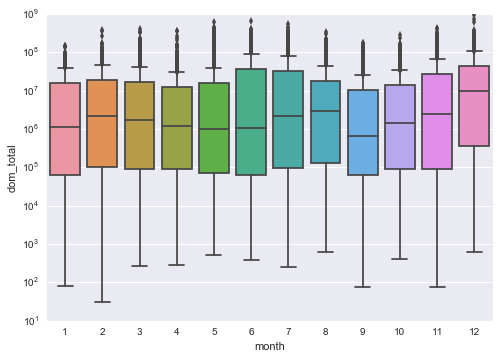

In [107]:
ax = sns.boxplot(x=movies_df["month"], y=movies_df["dom_total"])
ax.set_yscale("log")
sns.despine(trim=True)

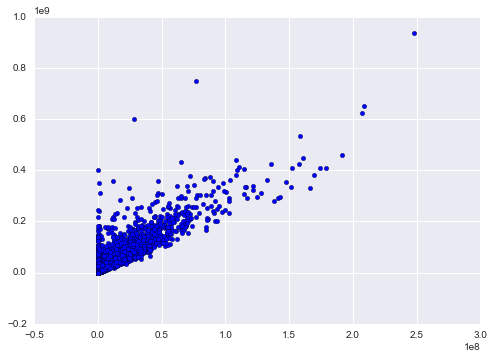

In [109]:
#create scatter plot of dom_total vs open_weekend
scttrplt = plt.scatter(movies_df["open_weekend"],movies_df["dom_total"])


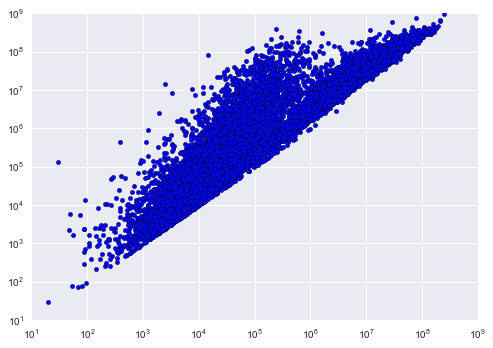

In [110]:
# create scatter plot on log scale of dom_total vs. open_weekend
scttrplt = plt.scatter(movies_df["open_weekend"],movies_df["dom_total"])
plt.xscale("log")
plt.yscale("log")

In [90]:
#cross validation - train test





# X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)

18